In [5]:
import numpy as np
import tcbench as tcb
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform
from functions import (build_faiss, 
                       search_faiss)

In [6]:
vectors_baseline = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/baseline_vectors.npy')
labels_baseline = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/baseline_labels.npy')
vectors_embeddings = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/embeddings_vectors.npy')
labels_embeddings = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/embeddings_labels.npy')

In [7]:
df = tcb.load_parquet(tcb.DATASETS.MIRAGE19, min_pkts=10)
df = df.drop(columns=['conn_id', 'android_name'])
df = df.rename(columns={'flow_metadata_bf_label': 'label', 
                        'flow_metadata_bf_labeling_type': 'labeling_type',
                        'packet_data_l4_raw_payload': 'raw_payload', 
                        'flow_metadata_bf_l4_payload_bytes': 'payload_bytes',
                        'flow_metadata_bf_duration': 'duration',
                        'timetofirst': 'time_to_first',})

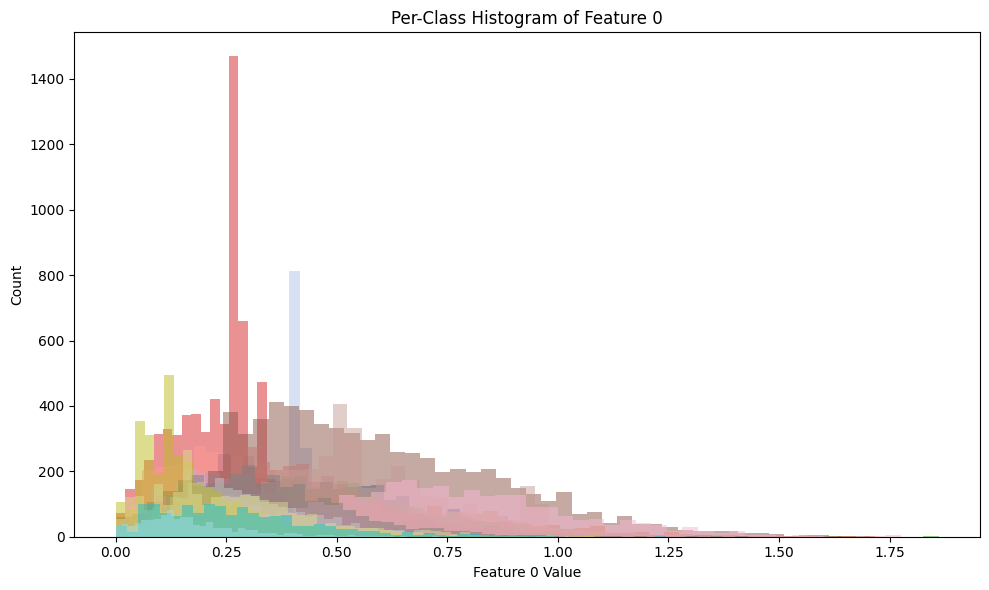

In [15]:
feature_idx = 0
unique_labels = np.unique(labels_embeddings)

plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, 20))

for label in unique_labels:
    class_feature_values = vectors_embeddings[labels_embeddings == label, feature_idx]
    plt.hist(class_feature_values, bins=50, alpha=0.5, label=f'Class {label}', density=True)

for idx,label in enumerate(unique_labels):
    color = colors[idx % 20]
    class_feature_values = vectors_embeddings[labels_embeddings == label, feature_idx]
    plt.hist(class_feature_values, bins=50, alpha=0.5, label=f'Class {label}', color=color)

plt.title('Per-Class Histogram of Feature 0')
plt.xlabel('Feature 0 Value')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

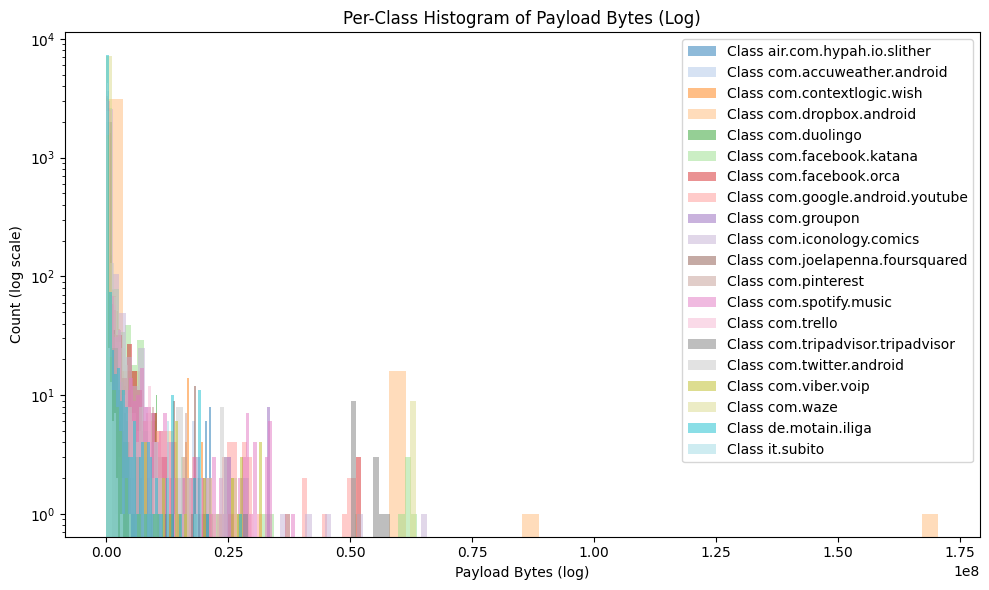

In [ ]:
payload_values = df['payload_bytes'].values
labels = df['label'].values
unique_labels = np.unique(labels)

plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, 20))

for idx, label in enumerate(unique_labels):
    color = colors[idx % 20]
    class_payload = payload_values[labels == label]
    plt.hist(class_payload, bins=50, alpha=0.5, label=f'Class {label}', log=True, color=color)

plt.title('Per-Class Histogram of Payload Bytes (Log)')
plt.xlabel('Payload Bytes (log)')
plt.ylabel('Count (log scale)')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
def calculate_within_class_distances(feature_matrix, true_labels, metric):
    class_distances = {}
    unique_labels = np.unique(true_labels)

    for label in unique_labels:
        class_indices = np.where(true_labels == label)[0]
        class_features = feature_matrix[class_indices]
        distances = squareform(pdist(class_features, metric))
        class_distances[label] = distances

    return class_distances

def calculate_between_class_distances(feature_matrix, true_labels, metric):
    class_distances = {}
    unique_labels = np.unique(true_labels)

    for label in unique_labels:
        class_indices = np.where(true_labels == label)[0]
        other_indices = np.where(true_labels != label)[0]
        class_features = feature_matrix[class_indices]
        other_features = feature_matrix[other_indices]
        distances = cdist(class_features, other_features, metric)
        class_distances[label] = distances

    return class_distances

In [4]:
def search_faiss_range(data, test_indices, index, metric):
    if metric == "distance":
        max_limit = np.inf
        lims, D, I = index.range_search(data[test_indices], max_limit)
        min_distance = np.sqrt(D[0])

    elif metric == "similarity":
        max_limit = 0
        query_vectors = data[test_indices]
        query_vectors = query_vectors / np.linalg.norm(query_vectors, axis=1, keepdims=True)
        lims, D, I = index.range_search(query_vectors, max_limit)
        min_distance = D[0]
    
    return min_distance

In [5]:
df_split = tcb.load_parquet(tcb.DATASETS.MIRAGE19, min_pkts=10, split=True)
train_val_indices = np.concatenate([df_split.iloc[0][0], df_split.iloc[0][1]])
test_indices = df_split.iloc[0][2]

In [6]:
print(labels_baseline[:2])
test_distances_within_baseline = calculate_within_class_distances(vectors_baseline[:2], labels_baseline[:2], metric='euclidean')
print(test_distances_within_baseline)

[6 6]
{6: array([[0.        , 1.01932718],
       [1.01932718, 0.        ]])}


In [7]:
test_index_baseline, test_selected_indices_baseline = build_faiss(vectors_baseline[:2], labels_baseline[:2], np.array([0]), 'euclidean', None)
test_coverage_percentage_baseline, test_match_percentage_baseline, test_min_distances_baseline = search_faiss(vectors_baseline[:2], labels_baseline[:2], np.array([1]), test_selected_indices_baseline, test_index_baseline, "distance", None)
print(test_min_distances_baseline)
test_min_distance_baseline = search_faiss_range(vectors_baseline[:2], np.array([1]), test_index_baseline, "distance")
print(test_min_distance_baseline)

[1.0193273]
1.0193273


In [8]:
print(labels_embeddings[:2])
test_distances_between_embeddings = calculate_between_class_distances(vectors_embeddings[:2], labels_embeddings[:2], metric='euclidean')
print(test_distances_between_embeddings)

[11 18]
{11: array([[3.61261807]]), 18: array([[3.61261807]])}


In [9]:
test_index_embeddings, test_selected_indices_embeddings = build_faiss(vectors_embeddings[:2], labels_embeddings[:2], np.array([0]), 'euclidean', None)
test_coverage_percentage_embeddings, test_match_percentage_embeddings, test_min_distances_embeddings = search_faiss(vectors_embeddings[:2], labels_embeddings[:2], np.array([1]), test_selected_indices_embeddings, test_index_embeddings, "distance", None)
print(test_min_distances_embeddings)
test_min_distance_embeddings = search_faiss_range(vectors_embeddings[:2], np.array([1]), test_index_embeddings, "distance")
print(test_min_distance_embeddings)

[3.612618]
3.612618


In [10]:
print(labels_embeddings[:2])
test_distances_between_embeddings_cosine = calculate_between_class_distances(vectors_embeddings[:2], labels_embeddings[:2], metric='cosine')
print(test_distances_between_embeddings_cosine)
test_similarities_between_embeddings_cosine = {
        label: 1 - distances for label, distances in test_distances_between_embeddings_cosine.items()
    }
print(test_similarities_between_embeddings_cosine)
    

[11 18]
{11: array([[0.2227783]]), 18: array([[0.2227783]])}
{11: array([[0.7772217]]), 18: array([[0.7772217]])}


In [11]:
test_index_embeddings_cosine, test_selected_indices_embeddings_cosine = build_faiss(vectors_embeddings[:2], labels_embeddings[:2], np.array([0]), 'cosine', None)
test_coverage_percentage_embeddings_cosine, test_match_percentage_embeddings_cosine, test_min_distances_embeddings_cosine = search_faiss(vectors_embeddings[:2], labels_embeddings[:2], np.array([1]), test_selected_indices_embeddings_cosine, test_index_embeddings_cosine, "similarity", None)
print(test_min_distances_embeddings_cosine)
test_min_distance_embeddings_cosine = search_faiss_range(vectors_embeddings[:2], np.array([1]), test_index_embeddings_cosine, "similarity")
print(test_min_distance_embeddings_cosine)

[0.7772217]
0.7772217
